In [1]:
# standard libraries
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, norm
from scipy import linalg, stats
from particles import resampling as rs
import time
import importlib
import sys
sys.path.append('..')

import GaussianMixtureAlgorithms as algo
import utils as u
importlib.reload(algo)
importlib.reload(u)

<module 'utils' from '/Users/francescacrucinio/Documents/PAPERS/SUBMITTED/SMC-WFR/GaussianMixture/../utils.py'>

In [2]:
d = 2
w = 1/3
mu1 = 3
mu2 = 9
sigma1 = 2
sigma2 = 0.7

In [3]:
weights = np.array([w, 1-w])
ms = np.array([mu1*np.ones(d), mu2*np.ones(d)])
Sigmas = np.array([sigma1*np.array([[1, -.8], [-.8, 1]]), sigma2*np.array([[1, .7], [.7, 1]])])
mu0 = np.zeros(d)
Sigma0 = np.eye(d)

Sigmas_inv = np.array([linalg.inv(Sigmas[0,:,:]), linalg.inv(Sigmas[1,:,:])])

In [4]:
x, y = np.mgrid[0:15:.01, 0:15:.01]
data = np.dstack((x, y))
z = 0
for j in range(weights.size):
    z += weights[j]*multivariate_normal.pdf(data, ms[j,:], Sigmas[j,:,:])


In [5]:
true_mean = np.mean(ms, axis = 0)
true_variance = np.zeros((d, d))
for i in range(2):
    true_variance += Sigmas[i, :, :] + np.matmul((ms[i, :] - true_mean)[:, None], (ms[i, :] - true_mean)[:, None].T)
true_variance = true_variance/2

## Algorithms

In [6]:
N = 300
X0 = np.random.multivariate_normal(np.zeros(d), np.eye(d), size = N)
gamma = 0.2

In [7]:
component = np.random.randint(2, size = N)
true_sample = np.zeros((N, d))
for n in range(N):
      true_sample[n, :] = np.random.multivariate_normal(ms[component[n], :], Sigmas[component[n], :, :], size = 1)[0]

In [8]:
Niter = 25000
# Niter_ula = int(Niter*4.7)
# Niter_mala = int(Niter*1.1)
# Niter_fr = int(Niter*1.6)
# Niter_smcula = int(Niter*3.5)
# Niter_smcmala = int(Niter)

Niter_ula = Niter
Niter_mala = Niter
Niter_fr = Niter
Niter_smcula = Niter
Niter_smcmala = Niter

In [9]:
gamma_mala = 0.25
gamma_smcmala = 0.25

In [10]:
Nalgo = 6
Nrep = 1

ula_chain = np.zeros((Nrep, Niter_ula, d, N))
mala_chain = np.zeros((Nrep, Niter_mala, d, N))
fr_x = np.zeros((Nrep, Niter_fr, d, N))
fr_w = np.zeros((Nrep, Niter_fr, N))
wfr_x = np.zeros((Nrep, Niter, d, N))
wfr_w = np.zeros((Nrep, Niter, N))
smcula_x = np.zeros((Nrep, Niter_smcula, d, N))
smcula_w = np.zeros((Nrep, Niter_smcula, N))
smcmala_x = np.zeros((Nrep, Niter_smcmala, d, N))
smcmala_w = np.zeros((Nrep, Niter_smcmala, N))

runtime = np.zeros((Nrep, Nalgo))

In [11]:
for i in range(Nrep):
    ## ULA
    start = time.time()
    ula_chain[i,:] = algo.ParallelULA(gamma, Niter_ula, ms, Sigmas, Sigmas_inv, weights, X0)
    end = time.time()
    runtime[i, 0] = end-start
#     ### MALA
#     start = time.time()
#     mala_chain[i,:], accepted_mala = algo.ParallelMALA(gamma_mala, Niter_mala, ms, Sigmas, Sigmas_inv, weights, X0)
#     end = time.time()
#     runtime[i, 1] = end-start
    ### SMC-FR
    start = time.time()
    fr_x[i,:], fr_w[i,:] = algo.SMC_UnitFR(gamma, Niter_fr, ms, Sigmas, weights, X0)
    end = time.time()
    runtime[i, 2] = end-start
    ### SMC-WFR
    start = time.time()
    wfr_x[i,:], wfr_w[i,:] = algo.SMC_WFR(gamma, Niter, ms, Sigmas, Sigmas_inv, weights, X0)
    end = time.time()
    runtime[i, 3] = end-start
#     ### SMC-ULA
#     start = time.time()
#     smcula_x[i,:], smcula_w[i,:] = algo.SMC_ULA(gamma, Niter_smcula, ms, Sigmas, Sigmas_inv, weights, X0)
#     end = time.time()
#     runtime[i, 4] = end-start
#     ### SMC-MALA
#     start = time.time()
#     smcmala_x[i,:], smcmala_w[i,:], accepted_smcmala = algo.SMC_MALA(gamma_smcmala, Niter_smcmala, ms, Sigmas, Sigmas_inv, weights, X0)
#     end = time.time()
#     runtime[i, 5] = end-start

/Users/francescacrucinio/Documents/PAPERS/SUBMITTED/SMC-WFR/GaussianMixture/GaussianMixtureAlgorithms.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(np.sum(logpi, axis = 0))


In [12]:
# np.mean(np.sum(accepted_mala, axis = 0)/Niter_mala)

In [13]:
# np.mean(np.sum(accepted_smcmala, axis = 0)/Niter_smcmala)

In [14]:
avg_runtime = np.mean(runtime, axis = 0)
avg_runtime[3]/avg_runtime

/var/folders/yb/2yx4lkb90l57vb9ljkzffpq40000gn/T/ipykernel_18778/884018888.py:2: RuntimeWarning: divide by zero encountered in divide
  avg_runtime[3]/avg_runtime


array([5.14038468,        inf, 1.94335468, 1.        ,        inf,
              inf])

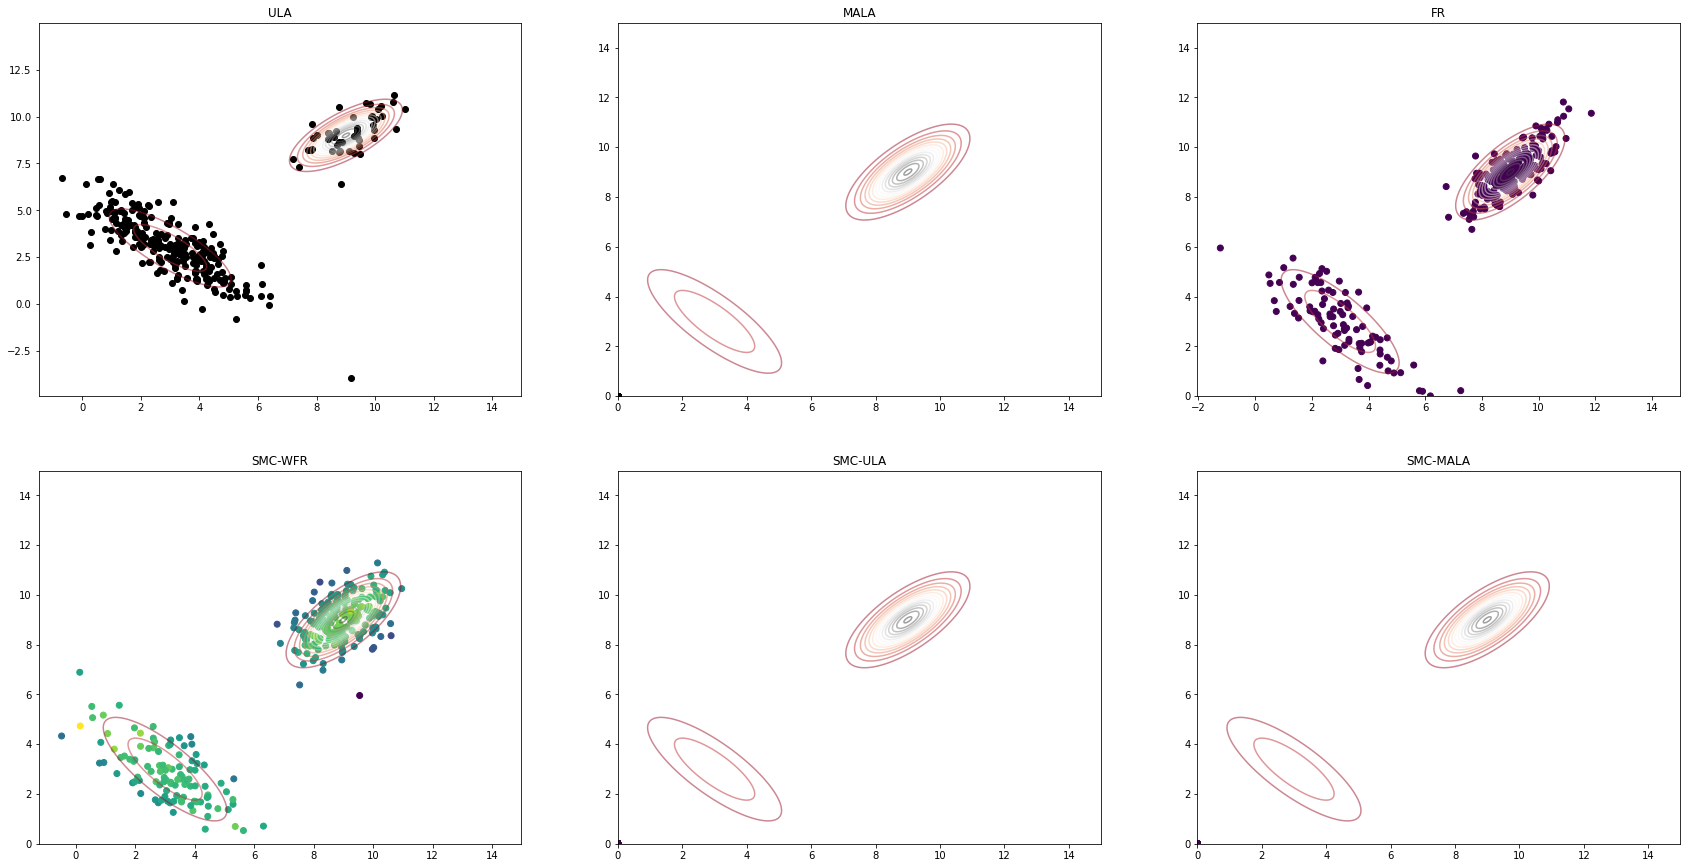

In [15]:
i = Nrep-1
plt.figure(figsize = (12,6))
plt.subplot(2, 3, 1)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(ula_chain[i, -1, 0, :], ula_chain[i, -1, 1, :], color = 'black');
plt.title('ULA')
plt.subplot(2, 3, 2)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(mala_chain[i, -1, 0, :], mala_chain[i, -1, 1, :], color = 'black');
plt.title('MALA')
plt.subplot(2, 3, 3)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(fr_x[i, -1, 0, :], fr_x[i, -1, 1, :], c = fr_w[i, -1, :]);
plt.title('FR')
plt.subplot(2, 3, 4)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(wfr_x[i, -1, 0, :], wfr_x[i, -1, 1, :], c = wfr_w[i, -1, :]);
plt.title('SMC-WFR')
plt.subplot(2, 3, 5)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(smcula_x[i, -1, 0, :], smcula_x[i, -1, 1, :], c = smcula_w[i, -1, :]);
plt.title('SMC-ULA')
plt.subplot(2, 3, 6)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(smcmala_x[i, -1, 0, :], smcmala_x[i, -1, 1, :], c = smcmala_w[i, -1, :]);
plt.title('SMC-MALA')
# plt.colorbar();
plt.subplots_adjust(left=-1,
                    bottom=-1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.2)
plt.show()
# plt.savefig('plot_gm.pdf', bbox_inches="tight")

In [16]:
xx_ula = avg_runtime[0]/Niter_ula*np.arange(Niter_ula)
xx_mala = avg_runtime[1]/Niter_mala*np.arange(Niter_mala)
xx_fr = avg_runtime[2]/Niter_fr*np.arange(Niter_fr)
xx_wfr = avg_runtime[3]/Niter*np.arange(Niter)
xx_smcula = avg_runtime[4]/Niter_smcula*np.arange(Niter_smcula)
xx_smcmala = avg_runtime[5]/Niter_smcmala*np.arange(Niter_smcmala)

In [17]:
w1_ula = np.zeros((Nrep, d, Niter_ula))
w1_mala = np.zeros((Nrep, d, Niter_mala))
w1_fr = np.zeros((Nrep, d, Niter_fr))
w1_wfr = np.zeros((Nrep, d, Niter))
w1_smcula = np.zeros((Nrep, d, Niter_smcula))
w1_smcmala = np.zeros((Nrep, d, Niter_smcmala))

mmd_ula = np.zeros((Nrep, Niter_ula))
mmd_mala = np.zeros((Nrep, Niter_mala))
mmd_fr = np.zeros((Nrep, Niter_fr))
mmd_wfr = np.zeros((Nrep, Niter))
mmd_smcula = np.zeros((Nrep, Niter_smcula))
mmd_smcmala = np.zeros((Nrep, Niter_smcmala))

# ksd_ula = np.zeros((Nrep, Niter_ula))
# ksd_mala = np.zeros((Nrep, Niter_mala))
# ksd_fr = np.zeros((Nrep, Niter_fr))
# ksd_wfr = np.zeros((Nrep, Niter))
# ksd_smcula = np.zeros((Nrep, Niter_smcula))
# ksd_smcmala = np.zeros((Nrep, Niter_smcmala))

cov_ula = np.zeros((Nrep, Niter_ula))
cov_mala = np.zeros((Nrep, Niter_mala))
cov_fr = np.zeros((Nrep, Niter_fr))
cov_wfr = np.zeros((Nrep, Niter))
cov_smcula = np.zeros((Nrep, Niter_smcula))
cov_smcmala = np.zeros((Nrep, Niter_smcmala))

In [18]:
for j in range(Nrep):
    for i in range(Niter_ula):
#         score_ula = algo.gradient_mixture(ula_chain[j, i, :, :], ms, Sigmas, weights)
#         ksd_ula[j, i] = u.kernel_stein_discrepancy_imq_weighted(ula_chain[j, i, :, :].T, score_ula.T)
        mmd_ula[j, i] = u.mmd_rbf(true_sample, ula_chain[j, i, :, :].T)
        cov_ula[j, i] = np.mean((np.cov(ula_chain[j, i, :, :]) - true_variance)**2)
        for k in range(d):
            w1_ula[j, k, i]  = stats.wasserstein_distance(ula_chain[j, i, k, :], true_sample[:, k])
    for i in range(Niter_mala):
#         score_mala = algo.gradient_mixture(mala_chain[j, i, :, :], ms, Sigmas, weights)
#         ksd_mala[j, i] = u.kernel_stein_discrepancy_imq_weighted(mala_chain[j, i, :, :].T, score_mala.T)
        mmd_mala[j, i] = u.mmd_rbf(true_sample, mala_chain[j, i, :, :].T)
        cov_mala[j, i] = np.mean((np.cov(mala_chain[j, i, :, :]) - true_variance)**2)
        for k in range(d):
            w1_mala[j, k, i]  = stats.wasserstein_distance(mala_chain[j, i, k, :], true_sample[:, k])
    for i in range(Niter):
#         score_wfr = algo.gradient_mixture(wfr_x[j, i, :, :], ms, Sigmas, weights)
#         ksd_wfr[j, i] = u.kernel_stein_discrepancy_imq_weighted(wfr_x[j, i, :, :].T, score_wfr.T, weights = wfr_w[j, i, :])
        mmd_wfr[j, i] = u.mmd_rbf(true_sample, wfr_x[j, i, :, :].T, w = wfr_w[j, i, :])
        cov_wfr[j, i] = np.mean((np.cov(wfr_x[j, i, :, :], aweights = wfr_w[j, i, :]) - true_variance)**2)
        for k in range(d):
            w1_wfr[j, k, i]  = stats.wasserstein_distance(wfr_x[j, i, k, :], true_sample[:, k], u_weights = wfr_w[j, i, :])
    for i in range(Niter_fr):
#         score_fr = algo.gradient_mixture(fr_x[j, i, :, :], ms, Sigmas, weights)
#         ksd_fr[j, i] = u.kernel_stein_discrepancy_imq_weighted(fr_x[j, i, :, :].T, score_fr.T, weights = fr_w[j, i, :])
        mmd_fr[j, i] = u.mmd_rbf(true_sample, fr_x[j, i, :, :].T, w = fr_w[j, i, :])
        cov_fr[j, i] = np.mean((np.cov(fr_x[j, i, :, :], aweights = fr_w[j, i, :]) - true_variance)**2)
        for k in range(d):
            w1_fr[j, k, i]  = stats.wasserstein_distance(fr_x[j, i, k, :], true_sample[:, k], u_weights = fr_w[j, i, :])
    for i in range(Niter_smcula):
#         score_smcula = algo.gradient_mixture(smcula_x[j, i, :, :], ms, Sigmas, weights)
#         ksd_smcula[j, i] = u.kernel_stein_discrepancy_imq_weighted(smcula_x[j, i, :, :].T, score_smcula.T, weights = smcula_w[j, i, :])
        mmd_smcula[j, i] = u.mmd_rbf(true_sample, smcula_x[j, i, :, :].T, w = smcula_w[j, i, :])
        cov_smcula[j, i] = np.mean((np.cov(smcula_x[j, i, :, :], aweights = smcula_w[j, i, :]) - true_variance)**2)
        for k in range(d):
            w1_smcula[j, k, i]  = stats.wasserstein_distance(smcula_x[j, i, k, :], true_sample[:, k], u_weights = smcula_w[j, i, :])
    for i in range(Niter_smcmala):
#         score_smcmala = algo.gradient_mixture(smcmala_x[j, i, :, :], ms, Sigmas, weights)
#         ksd_smcmala[j, i] = u.kernel_stein_discrepancy_imq_weighted(smcmala_x[j, i, :, :].T, score_smcmala.T, weights = smcmala_w[j, i, :])
        mmd_smcmala[j, i] = u.mmd_rbf(true_sample, smcmala_x[j, i, :, :].T, w = smcmala_w[j, i, :])
        cov_smcmala[j, i] = np.mean((np.cov(smcmala_x[j, i, :, :], aweights = smcmala_w[j, i, :]) - true_variance)**2)
        for k in range(d):
            w1_smcmala[j, k, i]  = stats.wasserstein_distance(smcmala_x[j, i, k, :], true_sample[:, k], u_weights = smcmala_w[j, i, :])
    

ZeroDivisionError: Weights sum to zero, can't be normalized

In [19]:
w1_ula_plot = np.mean(np.mean(w1_ula, axis = 1), axis = 0)
w1_mala_plot = np.mean(np.mean(w1_mala, axis = 1), axis = 0)
w1_fr_plot = np.mean(np.mean(w1_fr, axis = 1), axis = 0)
w1_wfr_plot = np.mean(np.mean(w1_wfr, axis = 1), axis = 0)
w1_smcula_plot = np.mean(np.mean(w1_smcula, axis = 1), axis = 0)
w1_smcmala_plot = np.mean(np.mean(w1_smcmala, axis = 1), axis = 0)

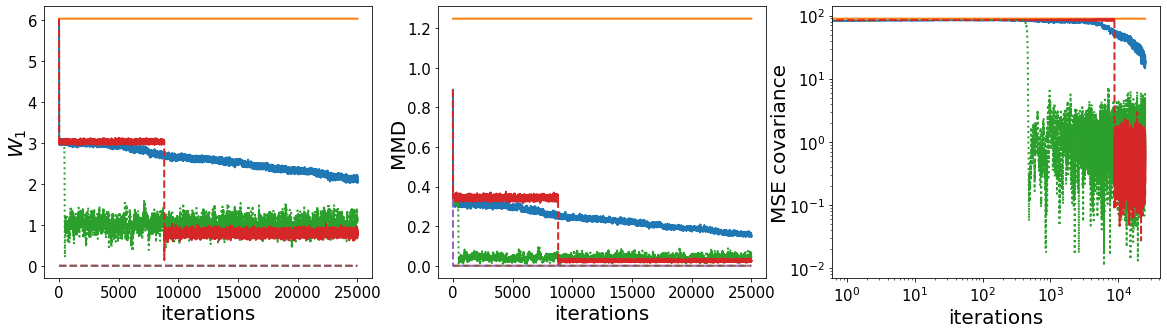

In [20]:
plt.figure(figsize = (20,5))
plt.subplot(1, 3, 1)
plt.plot(w1_ula_plot, label = 'ULA', lw = 2)
plt.plot(w1_mala_plot, label = 'MALA', lw = 2)
plt.plot(w1_fr_plot, label = 'SMC-tempering', lw = 2, linestyle = 'dotted')
plt.plot(w1_wfr_plot, label = 'SMC-WFR', lw = 2, linestyle = 'dashed')
plt.plot(w1_smcula_plot, label = 'SMC-ULA', lw = 2, linestyle = 'dashed')
plt.plot(w1_smcmala_plot, label = 'SMC-MALA', lw = 2, linestyle = 'dashed')
plt.xlabel('iterations', fontsize = 20)
plt.ylabel('$W_1$', fontsize = 20, labelpad=-1)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
# legend = plt.legend(loc = 'lower center', bbox_to_anchor=(1, -0.5), ncol = 6, fontsize = 20)
plt.subplot(1, 3, 2)
plt.plot(np.mean(mmd_ula, axis = 0), lw = 2)
plt.plot(np.mean(mmd_mala, axis = 0), lw = 2)
plt.plot(np.mean(mmd_fr, axis = 0), lw = 2, linestyle = 'dotted')
plt.plot(np.mean(mmd_wfr, axis = 0), lw = 2, linestyle = 'dashed')
plt.plot(np.mean(mmd_smcula, axis = 0), lw = 2, linestyle = 'dashed')
plt.plot(np.mean(mmd_smcmala, axis = 0), lw = 2, linestyle = 'dashed')
plt.xlabel('iterations', fontsize = 20)
plt.ylabel('MMD', fontsize = 20, labelpad=-1)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.subplot(1, 3, 3)
plt.loglog(np.mean(cov_ula, axis = 0), lw = 2)
plt.plot(np.mean(cov_mala, axis = 0), lw = 2)
plt.plot(np.mean(cov_fr, axis = 0), lw = 2, linestyle = 'dotted')
plt.plot(np.mean(cov_wfr, axis = 0), lw = 2, linestyle = 'dashed')
plt.plot(np.mean(cov_smcula, axis = 0), lw = 2, linestyle = 'dashed')
plt.plot(np.mean(cov_smcmala, axis = 0), lw = 2, linestyle = 'dashed')
plt.xlabel('iterations', fontsize = 20)
plt.ylabel('MSE covariance', fontsize = 20, labelpad=-1)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
# plt.savefig('conv_iter_gm.pdf', bbox_inches="tight")

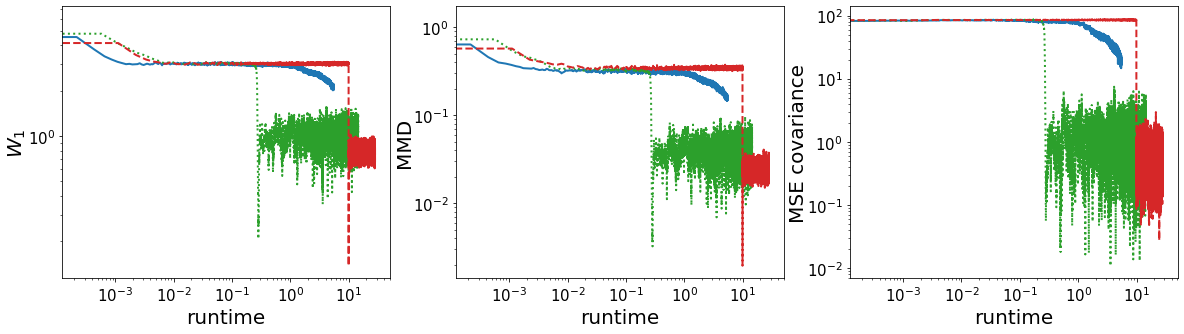

In [21]:
plt.figure(figsize = (20,5))
plt.subplot(1, 3, 1)
plt.loglog(xx_ula, w1_ula_plot, label = 'ULA', lw = 2)
plt.plot(xx_mala, w1_mala_plot, label = 'MALA', lw = 2)
plt.plot(xx_fr, w1_fr_plot, label = 'SMC-tempering', lw = 2, linestyle = 'dotted')
plt.plot(xx_wfr, w1_wfr_plot, label = 'SMC-WFR', lw = 2, linestyle = 'dashed')
plt.plot(xx_smcula, w1_smcula_plot, label = 'SMC-ULA', lw = 2, linestyle = 'dashed')
plt.plot(xx_smcmala, w1_smcmala_plot, label = 'SMC-MALA', lw = 2, linestyle = 'dashed')
plt.xlabel('runtime', fontsize = 20)
plt.ylabel('$W_1$', fontsize = 20, labelpad=-1)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.subplot(1, 3, 2)
plt.loglog(xx_ula, np.mean(mmd_ula, axis = 0), lw = 2)
plt.plot(xx_mala, np.mean(mmd_mala, axis = 0), lw = 2)
plt.plot(xx_fr, np.mean(mmd_fr, axis = 0), lw = 2, linestyle = 'dotted')
plt.plot(xx_wfr, np.mean(mmd_wfr, axis = 0), lw = 2, linestyle = 'dashed')
plt.plot(xx_smcula, np.mean(mmd_smcula, axis = 0), lw = 2, linestyle = 'dashed')
plt.plot(xx_smcmala, np.mean(mmd_smcmala, axis = 0), lw = 2, linestyle = 'dashed')
plt.xlabel('runtime', fontsize = 20)
plt.ylabel('MMD', fontsize = 20, labelpad=-1)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.subplot(1, 3, 3)
plt.loglog(xx_ula, np.mean(cov_ula, axis = 0), lw = 2)
plt.plot(xx_mala, np.mean(cov_mala, axis = 0), lw = 2)
plt.plot(xx_fr, np.mean(cov_fr, axis = 0), lw = 2, linestyle = 'dotted')
plt.plot(xx_wfr, np.mean(cov_wfr, axis = 0), lw = 2, linestyle = 'dashed')
plt.plot(xx_smcula, np.mean(cov_smcula, axis = 0), lw = 2, linestyle = 'dashed')
plt.plot(xx_smcmala, np.mean(cov_smcmala, axis = 0), lw = 2, linestyle = 'dashed')
plt.xlabel('runtime', fontsize = 20)
plt.ylabel('MSE covariance', fontsize = 20, labelpad=-1)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
# plt.savefig('conv_runtime_gm.pdf', bbox_inches="tight")

In [ ]:
# def export_legend(legend, filename="legend_comparison.pdf", expand=[-5,-5,5,5]):
#     fig  = legend.figure
#     fig.canvas.draw()
#     bbox  = legend.get_window_extent()
#     bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
#     bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
#     fig.savefig(filename, dpi="figure", bbox_inches=bbox)

# export_legend(legend)
# plt.show()

In [ ]:
# tmp = np.matrix(mmd_ula)
# with open('mmd_ula.txt','wb') as f:
#     for line in tmp:
#         np.savetxt(f, line)
# tmp = np.matrix(mmd_mala)
# with open('mmd_mala.txt','wb') as f:
#     for line in tmp:
#         np.savetxt(f, line)
# tmp = np.matrix(mmd_fr)
# with open('mmd_fr.txt','wb') as f:
#     for line in tmp:
#         np.savetxt(f, line)
# tmp = np.matrix(mmd_wfr)
# with open('mmd_wfr.txt','wb') as f:
#     for line in tmp:
#         np.savetxt(f, line)
# tmp = np.matrix(mmd_smcula)
# with open('mmd_smcula.txt','wb') as f:
#     for line in tmp:
#         np.savetxt(f, line)
# tmp = np.matrix(mmd_smcmala)
# with open('mmd_smcmala.txt','wb') as f:
#     for line in tmp:
#         np.savetxt(f, line)

In [ ]:
# tmp = np.matrix(ksd_ula)
# with open('ksd_ula.txt','wb') as f:
#     for line in tmp:
#         np.savetxt(f, line)
# tmp = np.matrix(ksd_mala)
# with open('ksd_mala.txt','wb') as f:
#     for line in tmp:
#         np.savetxt(f, line)
# tmp = np.matrix(ksd_fr)
# with open('ksd_fr.txt','wb') as f:
#     for line in tmp:
#         np.savetxt(f, line)
# tmp = np.matrix(ksd_wfr)
# with open('ksd_wfr.txt','wb') as f:
#     for line in tmp:
#         np.savetxt(f, line)
# tmp = np.matrix(ksd_smcula)
# with open('ksd_smcula.txt','wb') as f:
#     for line in tmp:
#         np.savetxt(f, line)
# tmp = np.matrix(ksd_smcmala)
# with open('ksd_smcmala.txt','wb') as f:
#     for line in tmp:
#         np.savetxt(f, line)

In [ ]:
# tmp = np.matrix(np.mean(w1_ula, axis = 1))
# with open('w1_ula.txt','wb') as f:
#     for line in tmp:
#         np.savetxt(f, line)
# tmp = np.matrix(np.mean(w1_mala, axis = 1))
# with open('w1_mala.txt','wb') as f:
#     for line in tmp:
#         np.savetxt(f, line)
# tmp = np.matrix(np.mean(w1_fr, axis = 1))
# with open('w1_fr.txt','wb') as f:
#     for line in tmp:
#         np.savetxt(f, line)
# tmp = np.matrix(np.mean(w1_wfr, axis = 1))
# with open('w1_wfr.txt','wb') as f:
#     for line in tmp:
#         np.savetxt(f, line)
# tmp = np.matrix(np.mean(w1_smcula, axis = 1))
# with open('w1_smcula.txt','wb') as f:
#     for line in tmp:
#         np.savetxt(f, line)
# tmp = np.matrix(np.mean(w1_smcmala, axis = 1))
# with open('w1_smcmala.txt','wb') as f:
#     for line in tmp:
#         np.savetxt(f, line)

In [ ]:
# parameters = np.matrix(avg_runtime)
# with open('times.txt','wb') as f:
#     for line in parameters:
#         np.savetxt(f, line)

## Zoom into SMC tempering & SMC-WFR

In [22]:
w1_fr_se = 2*np.std(np.mean(w1_fr, axis = 1), axis = 0)
w1_wfr_se = 2*np.std(np.mean(w1_wfr, axis = 1), axis = 0)

mmd_fr_se = 2*np.std(mmd_fr, axis = 0)
mmd_wfr_se = 2*np.std(mmd_wfr, axis = 0)

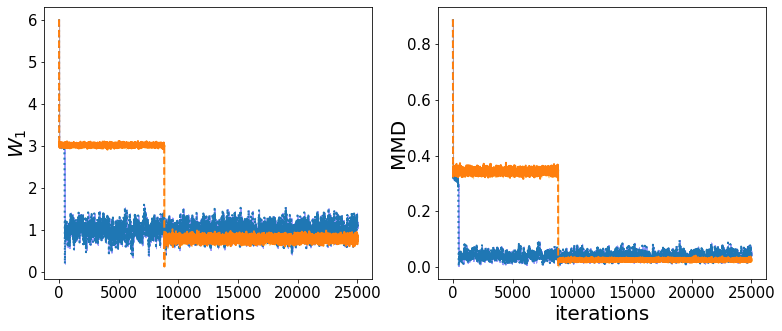

In [23]:
plt.figure(figsize = (20,5))
plt.subplot(1, 3, 1)
plt.plot(w1_fr_plot, label = 'SMC-tempering', lw = 2, linestyle = 'dotted')
plt.fill_between(np.arange(Niter_fr), (w1_fr_plot-w1_fr_se), (w1_fr_plot+w1_fr_se), color='b', alpha=.4)
plt.plot(w1_wfr_plot, label = 'SMC-WFR', lw = 2, linestyle = 'dashed')
plt.fill_between(np.arange(Niter), (w1_wfr_plot-w1_wfr_se), (w1_wfr_plot+w1_wfr_se), color='orange', alpha=.4)
plt.xlabel('iterations', fontsize = 20)
plt.ylabel('$W_1$', fontsize = 20, labelpad=-1)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
# legend = plt.legend(loc = 'lower center', bbox_to_anchor=(1, -0.5), ncol = 6, fontsize = 20)
plt.subplot(1, 3, 2)
plt.plot(np.mean(mmd_fr, axis = 0), lw = 2, linestyle = 'dotted')
plt.fill_between(np.arange(Niter_fr), (np.mean(mmd_fr, axis = 0)-mmd_fr_se), (np.mean(mmd_fr, axis = 0)+mmd_fr_se), color='b', alpha=.4)
plt.plot(np.mean(mmd_wfr, axis = 0), lw = 2, linestyle = 'dashed')
plt.fill_between(np.arange(Niter), (np.mean(mmd_wfr, axis = 0)-mmd_wfr_se), (np.mean(mmd_wfr, axis = 0)+mmd_wfr_se), color='orange', alpha=.4)
plt.xlabel('iterations', fontsize = 20)
plt.ylabel('MMD', fontsize = 20, labelpad=-1)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

In [25]:
algo.gradient_mixture(np.array([[4, 7]]).T, ms, Sigmas, Sigmas_inv, weights)

array([[-5.203651  ],
       [-6.56915317]])

In [26]:
np.array([[4, 7]]).T

array([[4],
       [7]])